In [68]:
import os
import sys
import json5
import numpy as np
import scipy
from itertools import tee, chain
from collections import defaultdict, Counter

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [69]:
block_root = '/ddr'
v_path = os.path.join(block_root, '/rtl/cadence_ddr_controller.v.preproc.v')
comp_json_path = os.path.join(block_root, 'ddr.json5')
with open(comp_json_path) as fin:
    block = json5.load(fin)
ports = []
for name, pw in block['definitions']['ports'].items():
    try:
        w, d = np.abs(pw), np.sign(pw)
    except Exception as e:
        print('Warning', (name, pw), 'not correctly parsed')
        w, d = None, np.sign(-1) if pw[0] == '-' else np.sign(1)
    ports.append( (name, w, d) )

Warning ('regHADDR', 'PAR_REG_ADDR_WIDTH + 2') not correctly parsed
Warning ('phy_reg_addr', '-(PAR_REG_ADDR_WIDTH)') not correctly parsed


In [70]:
def words_from_name(wire, pad=False):
    words = wire.split('_')
    if pad:
        return chain([None], words, [None])
    else:
        return words

class GroupVectorizer(object):
    @property
    def size(self): return self._size
    def __init__(self, words):
        self._idx_word_map = dict(enumerate(words))
        self._word_idx_map = dict(
            [(v, k) for (k, v) in enumerate(words)],
        )
        self._size = len(words)
        
    def get_vec(self, words):
        v = np.zeros(self.size, dtype=bool)
        for w in words:
            assert w in self._word_idx_map
            v[self._word_idx_map[w]] = True
        return v
    
    def get_attrs(self):
        return np.array(list(map(
            lambda x: x[1],
            sorted(self._idx_word_map.items()),
        )))
    
class Vectorizer(object):
    @property
    def size(self): return sum([gv.size for _, gv in self.group_vectorizers.items()])
    @property
    def max_words(self): return self._max_words
                               
    def __init__(self, wire_names):
        group_words = defaultdict(set)
        #words = set()
        
        # determine number of word groups based on wire_names
        idx = np.argmax(list(map(
            lambda x: len(list(words_from_name(x, pad=True))),
            wire_names,
        )))
        mwire = wire_names[idx]
        self._max_words = len(list(words_from_name(mwire, pad=True)))
        
        for wire_name in wire_names:
            for i, (w1, w2) in self.__iter_groups__(wire_name):
                for w in w1, w2:
                    group_words[i].add(w)
                    #if w != None:
                    #    words.add(w)
        self.group_vectorizers = dict([(i, GroupVectorizer(words)) for (i, words) in group_words.items()])
        
    def __words_from_name__(self, wire_name):
        base_words = list(words_from_name(wire_name, pad=True))
        slop = self._max_words - len(base_words)
        # can pad with the wire_name itself so wires with smaller 
        # number of words are not biased to cluster with each other
        #pad = None
        pad = wire_name
        return chain(base_words, [pad]*slop)
    
    def __iter_groups__(self, wire_name):
        return enumerate(pairwise(self.__words_from_name__(wire_name)))
        
    def get_vec(self, wire_name):
        vs = np.hstack(
            [self.group_vectorizers[i].get_vec(words)
                for i, words in self.__iter_groups__(wire_name)]
        )
        return np.hstack(vs)
    
    def get_attrs(self):
        return np.hstack([gv.get_attrs() for i, gv in sorted(self.group_vectorizers.items())])


In [71]:
wire_names = list(map(lambda w: w[0], ports))
v = Vectorizer(wire_names)

In [72]:
def get_ports():
    ws = list(ports)
    #return ws
    ws = ws[:40]
    def swap(i, j):
        ws[i], ws[j] = ws[j], ws[i]
    swap(1,18)
    swap(5,11)
    return ws

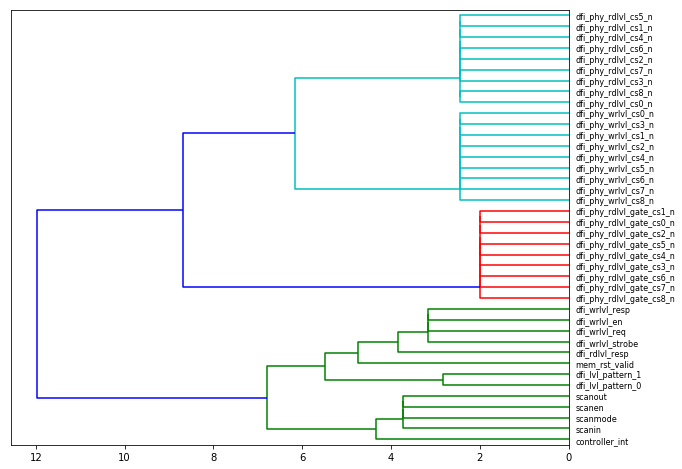

In [73]:
from matplotlib import pyplot as pyplot
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, to_tree

ports = get_ports()
wire_names = [p[0] for p in ports]
vs = [v.get_vec(name) for name in wire_names]
X = np.vstack(vs)
Z = linkage(X, 'ward')
#print(Z[:,:])

fig, ax = pyplot.subplots(1,1, figsize=(10,8))
dendrogram(
    Z,
    ax=ax,
    orientation='left',
    labels=wire_names,
)
pyplot.show()

In [74]:
# ClusterNode helpers
def pre_order_n(node, func=(lambda x: x.id)):
    """
    modified from ClusterNode src to invoke func at non-leaf nodes as well
    """
    # Do a preorder traversal, caching the result. To avoid having to do
    # recursion, we'll store the previous index we've visited in a vector.
    n = node.count
    
    curNode = [None] * (2 * n)
    lvisited = set()
    rvisited = set()
    curNode[0] = node
    k = 0
    preorder = []
    while k >= 0:
        nd = curNode[k]
        ndid = nd.id
        if nd.is_leaf():
            preorder.append(func(nd))
            k = k - 1
        else:
            if ndid not in lvisited:
                curNode[k + 1] = nd.left
                lvisited.add(ndid)
                k = k + 1
            elif ndid not in rvisited:
                curNode[k + 1] = nd.right
                rvisited.add(ndid)
                k = k + 1
            # If we've visited the left and right of this non-leaf
            # node already, go up in the tree.
            else:
                k = k - 1
                preorder.append(func(nd))
    
    return preorder

def add_parent(node, parent):
    node.parent = parent
    
def tag_parent(node):
    if not node.is_leaf():
        add_parent(node.get_left(), node)
        add_parent(node.get_right(), node)

In [75]:
class PortGrouper(object):
    """
    Build a tree off an input hierarchical clustering linkage matrix Z
    
    Yield all parent groupings of a given input wire
    """
    def __init__(self, ports, Z):
        self.root_node, self.node_list = to_tree(Z, rd=True)

        # default no parents
        for n in self.node_list:
            add_parent(n, None)
        # traverse tree and tag parents
        _ = pre_order_n(self.root_node, tag_parent)
    
        leaves = list(filter(lambda n: n.is_leaf(), self.node_list))
        self.wire_node_map = dict(zip(
            ports,
            sorted(leaves, key=lambda n: n.id),
        ))
        self.id_wire_map = {v.id:k for k,v in self.wire_node_map.items()}
        self.leaf_ids = set(map(lambda n: n.id, leaves))
        
    def get_group_leaves(self, node):
        return list(filter(
            lambda n: n.id in self.leaf_ids,
            pre_order_n(node, lambda n: n),
        ))
    
    def get_port_groups(self, wire):
        assert wire in self.wire_node_map
        curr = self.wire_node_map[wire]
        assert curr.parent is not None
        # traverse up until the root
        while curr is not None:
            group = self.get_group_leaves(curr)
            yield set(map(lambda n: self.id_wire_map[n.id], group))
            curr = curr.parent
        
port = ports[34]
pg = PortGrouper(ports, Z)
for i, group in enumerate(pg.get_port_groups(port)):
    print('group {}, size: {}'.format(i, len(group)))
    for wire in group:
        print('  - ', wire)

group 0, size: 1
  -  ('dfi_phy_rdlvl_gate_cs5_n', 2, 1)
group 1, size: 2
  -  ('dfi_phy_rdlvl_gate_cs5_n', 2, 1)
  -  ('dfi_phy_rdlvl_gate_cs4_n', 2, 1)
group 2, size: 5
  -  ('dfi_phy_rdlvl_gate_cs1_n', 2, 1)
  -  ('dfi_phy_rdlvl_gate_cs2_n', 2, 1)
  -  ('dfi_phy_rdlvl_gate_cs0_n', 2, 1)
  -  ('dfi_phy_rdlvl_gate_cs5_n', 2, 1)
  -  ('dfi_phy_rdlvl_gate_cs4_n', 2, 1)
group 3, size: 6
  -  ('dfi_phy_rdlvl_gate_cs2_n', 2, 1)
  -  ('dfi_phy_rdlvl_gate_cs1_n', 2, 1)
  -  ('dfi_phy_rdlvl_gate_cs0_n', 2, 1)
  -  ('dfi_phy_rdlvl_gate_cs3_n', 2, 1)
  -  ('dfi_phy_rdlvl_gate_cs5_n', 2, 1)
  -  ('dfi_phy_rdlvl_gate_cs4_n', 2, 1)
group 4, size: 7
  -  ('dfi_phy_rdlvl_gate_cs6_n', 2, 1)
  -  ('dfi_phy_rdlvl_gate_cs2_n', 2, 1)
  -  ('dfi_phy_rdlvl_gate_cs1_n', 2, 1)
  -  ('dfi_phy_rdlvl_gate_cs0_n', 2, 1)
  -  ('dfi_phy_rdlvl_gate_cs3_n', 2, 1)
  -  ('dfi_phy_rdlvl_gate_cs5_n', 2, 1)
  -  ('dfi_phy_rdlvl_gate_cs4_n', 2, 1)
group 5, size: 8
  -  ('dfi_phy_rdlvl_gate_cs6_n', 2, 1)
  -  ('dfi_phy_rdl

In [76]:
import editdistance as ed

#wire_names = list(map(lambda w: w[0], ports))
#wire_attrs = dict(map(lambda w: (w[0], (w[1:])), ports))

def match_cost(phy_port, bus_port):
    
    def name_dist(w1, w2):
        #return ed.eval(w1, w2)
        return ed.eval(w1, w2) / max(len(w1), len(w2))
    
    p_words = words_from_name(phy_port[0].lower())
    b_words = words_from_name(bus_port[0].lower())
    cost_n = 0
    for b_word in b_words:
        cost_n += min(map(lambda w: name_dist(b_word, w), p_words))
    
    return (
        # name attr mismatch
        cost_n + 
        # width mismatch
        1*(phy_port[1] != bus_port[1]) +
        # direction mismatch
        1*(phy_port[2] != bus_port[2])
    )

In [77]:
import cvxopt
from cvxopt import matrix, solvers
from cvxopt.modeling import variable, dot, op
from cvxopt.modeling import sum as cvx_sum

solvers.options['show_progress'] = False

def map_port_sets(ports1, ports2):
    ports1 = list(ports1)
    ports2 = list(ports2)
    m, n  = len(ports1), len(ports2)
    swap = False
    if m > n:
        swap = True
        m, n = n, m
        ports1, ports2 = ports2, ports1
    C = np.zeros((m, n))
    for i, p1 in enumerate(ports1):
        for j, p2 in enumerate(ports2):
            C[i,j] = match_cost(p1, p2)
    
    c = matrix(C.reshape(m*n))
    x = variable(m*n)
    constraints = [
        x >= 0,
        x <= 1,
    ]
    for i in range(m):
        #print('setting constraint', i*n, i*n+n)
        constraints.append(
            cvx_sum(x[i*n:i*n+n]) == 1
        )
        
    # add constraints so max number of assignments 
    # to each port in ports2 is 1 as well
    for j in range(n):
        #print(list(range(j, m*n, n)))
        constraints.append(
            cvx_sum([x[jj] for jj in range(j, m*n, n)]) <= 1
        )
    op(
        dot(c, x),
        constraints,
    ).solve()
    X = np.array(x.value).reshape(m,n) > 0.01
    
    mapping = {ports1[i] : ports2[j] for i, j in np.argwhere(X)}
    cost = get_mapping_cost(mapping, ports1, ports2)
    if swap:
        return {v:k for k, v in mapping.items()}, cost
    else:
        return mapping, cost

def get_mapping_cost(mapping, ports1, ports2):
    umap1 = set(ports1) - set(mapping.keys())
    umap2 = set(ports2) - set(mapping.values())
    cost = 0
    cost += sum([match_cost(p1, p2) for p1, p2 in mapping.items()])
    nil_port = ('', None, None)
    cost += sum([match_cost(nil_port, p) for p in umap1])
    cost += sum([match_cost(nil_port, p) for p in umap2])
    return cost
    
phy = [
    ('ready1', 1, 1),
    ('ready2', 1, 1),
    ('ready3', 1, 1),
    #('xxxx', 1, 1),
    #('yyyx', 1, 1),
]
bus = [
    ('rdy3', 1, 1),
    ('rdy1', 1, 1),
    ('rdy2', 1, 1),
]
mapping = map_port_sets(phy, bus)
print(mapping)

({('ready1', 1, 1): ('rdy1', 1, 1), ('ready2', 1, 1): ('rdy2', 1, 1), ('ready3', 1, 1): ('rdy3', 1, 1)}, 1.0)


In [78]:
pg = PortGrouper(ports, Z)
assn_ports = set()

bus_def = [
    ('dfi_wrlvl_strobe', 9, -1),
    ('dfi_wrlvl_en', 1, 1),
    ('dfi_wrlvl_resp', 1, 1),
]
for ii, port in enumerate(ports):
    if port[0] != 'dfi_wrlvl_strobe':
        continue
    # only assign ports to a single bus definition
    if port in assn_ports:
        continue
    mappings = []
    #print('root port', port)
    for i, port_group in enumerate(pg.get_port_groups(port)):
        mapping, cost = map_port_sets(port_group, bus_def)
        mappings.append((cost, port_group, mapping))
        #print('  - port group', port_group)
        #print('    - mapping', mapping, cost)
    cost, cport_group, cmapping = min(mappings)
    assn_ports |= set(cport_group)
    print(cport_group, cmapping, cost)


{('dfi_wrlvl_strobe', 9, -1), ('dfi_wrlvl_resp', 9, 1), ('dfi_wrlvl_req', 9, 1), ('dfi_wrlvl_en', 9, -1)} {('dfi_wrlvl_strobe', 9, -1): ('dfi_wrlvl_strobe', 9, -1), ('dfi_wrlvl_req', 9, 1): ('dfi_wrlvl_en', 1, 1), ('dfi_wrlvl_resp', 9, 1): ('dfi_wrlvl_resp', 1, 1)} 7.66666666667


In [79]:
busdef_spec_rootdir = '/bus-defs/specs'

class dotdict(dict):
    """
    quick and dirty addition to allow access to bus defs using just dot operator
    dot.notation access to dictionary attributes
    """
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

class BusDef(object):
    
    @classmethod
    def is_spec_bus_def(cls, spec_path):
        if not spec_path.endswith('json5'):
            return False
        try:
            with open(spec_path) as fin:
                spec = json5.load(fin)
        except:
            print('Warning, could not load {} with json5 parser'.format(spec_path))
            return False
        return 'abstractionDefinition' in spec

    @classmethod
    def bus_defs_from_spec(cls, spec_path):
        """
        parse spec def and create the described slave+master bus interfaces 
        """
        with open(spec_path) as fin:
            spec = json5.load(fin)
        adkey = 'abstractionDefinition'
        bus_type = dotdict(spec[adkey]['busType'])
        abstract_type = dotdict({
            'vendor'  : spec[adkey]['vendor'],
            'library' : spec[adkey]['library'],
            'name'    : spec[adkey]['name'],
            'version' : spec[adkey]['version'],
        })
        
        master_req_ports = []
        master_opt_ports = []
        slave_req_ports = []
        slave_opt_ports = []
        
        for portname, portdef in spec[adkey]['ports'].items():
            req_port_map, opt_port_map = cls.parse_port(portname, portdef)
            if 'onMaster' in req_port_map: master_req_ports.append(req_port_map['onMaster'])
            if 'onMaster' in opt_port_map: master_opt_ports.append(opt_port_map['onMaster'])
            if 'onSlave'  in req_port_map: slave_req_ports.append(req_port_map['onSlave'])
            if 'onSlave'  in opt_port_map: slave_opt_ports.append(opt_port_map['onSlave'])
        
        #print('num master req ports', len(master_req_ports))
        #print('num master opt ports', len(master_opt_ports))
        #print('num slave req ports', len(slave_req_ports))
        #print('num slave opt ports', len(slave_opt_ports))
        
        bus_defs = []
        if master_req_ports != []:
            bus_defs.append(
                BusDef(
                    bus_type,
                    abstract_type, 
                    'master',
                    master_req_ports,
                    master_opt_ports,
                )
            )
        if slave_req_ports != []:
            bus_defs.append(
                BusDef(
                    bus_type,
                    abstract_type, 
                    'slave',
                    slave_req_ports,
                    slave_opt_ports,
                )
            )
        return bus_defs
            
    @classmethod
    def parse_port(cls, portname, portdef):
        assert set([
            'logicalName',
            'wire',
        ]).issubset(set(portdef.keys())), \
            "required keys missing in description of port {}".format(portname)
        logical_name = portdef['logicalName']
        req_port_map = defaultdict(lambda: None)
        opt_port_map = defaultdict(lambda: None)
        for type_key in ['onMaster', 'onSlave']:
            if type_key not in portdef['wire']:
                continue
            subportdef = portdef['wire'][type_key]
            assert (
                set([
                    'presence',
                    'direction',
                    #'width',
                ]).issubset(set(subportdef.keys())) 
                or
                ('presence' in subportdef and subportdef['presence'] == 'illegal')
            ), \
                "required keys missing in {} description of port {}".format(
                    type_key, logical_name,
                )
            assert subportdef['presence'] in ['required', 'optional', 'illegal']
            # FIXME handle illegal separately
            if subportdef['presence'] == 'illegal':
                continue
                
            width = None if 'width' not in subportdef else int(subportdef['width'])
            direction = np.sign(1) if subportdef['direction'] == 'out' else np.sign(-1)
            desc = (logical_name, width, direction)
            if subportdef['presence'] == 'required':
                req_port_map[type_key] = desc
            else:
                opt_port_map[type_key] = desc
                
        return req_port_map, opt_port_map
    
    @property
    def num_req_ports(self): return len(self._req_ports)
    @property
    def num_opt_ports(self): return len(self._opt_ports)
    @property
    def req_ports(self): return list(self._req_ports)
    @property
    def opt_ports(self): return list(self._opt_ports)
    
    def words_from_name(port_name):
        return [
            self.bus_type.name, 
            #self.bus_type.library, 
            port_name,
        ]
    
    def __init__(
        self,
        bus_type,
        abstract_type, 
        driver_type,
        req_ports,
        opt_ports,
    ):
        self.bus_type      = bus_type
        self.abstract_type = abstract_type
        self.driver_type   = driver_type
        self._req_ports     = req_ports
        self._opt_ports     = opt_ports
        
        
spec_path = '/bus-defs/specs/amba.com/AMBA4/AXI4/r0p0_0/AXI4_rtl.json5'
print('{} has bus defs {}'.format(spec_path, BusDef.is_spec_bus_def(spec_path)))


print('loading bus defs from specs')
bus_defs = []
for root, dirs, fnames in os.walk(busdef_spec_rootdir):
    #print((root, dirs, files))
    for fname in fnames:
        spec_path = os.path.join(root, fname)
        if BusDef.is_spec_bus_def(spec_path):
            print('  - loading ', spec_path)
            bus_defs.extend(
                BusDef.bus_defs_from_spec(spec_path)
            )
print('  - done')
print('loaded {} bus definitions from specs'.format(len(bus_defs)))
print('  - total req ports', sum([bd.num_req_ports for bd in bus_defs]))
print('  - total opt ports', sum([bd.num_opt_ports for bd in bus_defs]))
            
            
            

/bus-defs/specs/amba.com/AMBA4/AXI4/r0p0_0/AXI4_rtl.json5 has bus defs True
loading bus defs from specs
  - loading  /bus-defs/specs/amba.com/AMBA2/AHB/r3p0_1/AHB_rtl.json5
  - loading  /bus-defs/specs/amba.com/AMBA5/AHB5Target/r0p0_0/AHB5Target_rtl.json5
  - loading  /bus-defs/specs/amba.com/AMBA5/AHB5Initiator/r0p0_0/AHB5Initiator_rtl.json5
  - loading  /bus-defs/specs/amba.com/AMBA4/AXI4Stream/r0p0_1/AXI4Stream_rtl.json5
  - loading  /bus-defs/specs/amba.com/AMBA4/AXI4/r0p0_0/AXI4_rtl.json5
  - loading  /bus-defs/specs/amba.com/AMBA4/AXI4/r0p0_0/AXI4_RO_rtl.json5
  - loading  /bus-defs/specs/amba.com/AMBA4/ACE-Lite/r0p0_0/ACE-Lite_rtl.json5
  - loading  /bus-defs/specs/amba.com/AMBA4/APB4/r0p0_0/APB4_rtl.json5
  - loading  /bus-defs/specs/amba.com/AMBA4/ATB/r0p0_0/ATB_rtl.json5
  - loading  /bus-defs/specs/amba.com/AMBA4/ACP/r0p0_0/ACP_rtl.json5
  - loading  /bus-defs/specs/amba.com/AMBA4/ACE/r0p0_0/ACE_rtl.json5
  - loading  /bus-defs/specs/amba.com/AMBA3/AHBLite/r2p0_0/AHBLite_rtl